In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from scipy.linalg import svd, inv, eig
from scipy.special import erf

#sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running locally on beta.


In [17]:
import utils

In [18]:
def plot_matrix(m, ax, scale=1.0, transpose=False, numlines=None):
    m = np.copy(m)
    mmax = np.max(np.abs(m)) / scale
    if transpose:
        m = m.T
    if numlines is not None:
        m = m[:numlines]
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

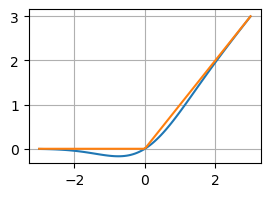

In [19]:
def gelu(x):
    return x / 2 * (1 + erf(x / np.sqrt(2)))

def relu(x):
    return np.maximum(x, 0)

fig, ax = plt.subplots(1,1,figsize=(3,2))
x_range = np.linspace(-3,3,100)
ax.plot(x_range, gelu(x_range));
ax.plot(x_range, relu(x_range));
ax.grid(True)

In [20]:
def plot_fft(mat, ax, shift=+np.pi/2, scale=1):
    
    fft = np.fft.rfft(mat, axis=-1)
    fft_abs, fft_arg = np.abs(fft), np.angle(fft)

    fft_arg += np.pi
    fft_arg[1::2] += shift
    fft_arg = fft_arg % (2*np.pi)

    hue = fft_arg / (2*np.pi)
    saturation = np.clip(fft_abs / np.max(fft_abs) * scale, 0, 1)
    value = np.ones_like(hue)
    hsv = np.stack([hue, saturation, value], axis=-1)
    rgb = hsv_to_rgb(hsv)
    y_max, x_max = rgb.shape[:2]

    ax.imshow(rgb, interpolation="nearest")

    ax.grid(True, which="minor", color='black', linewidth=0.5, alpha=0.1)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which="major", color='black', linewidth=0.5, alpha=0.3)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))

In [21]:
def plot_usv(i):
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    plot_matrix(w[i][:], axs[0])
    plot_matrix(s[i][:], axs[1])
    plot_matrix(u[i][:],  axs[2])
    plot_matrix(vt[i][:], axs[3])

In [22]:
run = utils.TrainingRun()
P, model = run.load_state("/cloud/markus/gdrive/output/modulo_add_mlp_A-230503-155613/")
#P, model = run.load_state("/home/markus/runs/dl_basics/mlp_mod_arith-230421-080708/")
#P, model = run.load_state("/home/markus/runs/dl_basics/mlp_mod_arith-230421-091336/")


In [23]:
#model.load_weights("/home/markus/runs/dl_basics/mlp_mod_arith-230421-080708/weights-epoch-000002.hdf5")

In [24]:
P, run.current_epoch

({'addition_modulo_data': {'p_max': 113,
   'train_size': 0.3,
   'add_equal_sign': False,
   'seed': 42},
  'model_name': 'modulo_add_mlp_A',
  'model_build_params': {'seq_len': 2,
   'vocab_size': 113,
   'embed_dim': 128,
   'mlp_dim': 128,
   'regularizer': None,
   'use_bias': False,
   'lambda_emb_loss': 0.0},
  'random_seed': 42,
  'loss': 'SparseCategoricalCrossentropy(from_logits=True)',
  'optimizer': 'AdamW(1e-3, weight_decay=1)',
  'metrics': ['accuracy'],
  'run_dir': 'modulo_add_mlp_A-230503-155613'},
 2048)

In [25]:
w = model.get_weights()
print([ wi.shape for wi in w ])

[(113, 128), (128, 113)]


In [26]:
u, s, vt = [], [], []
for wi in w:
    if len(wi.shape) == 1:
        continue
    ui, si_array, vti = svd(wi)
    u.append(ui)
    si = np.zeros_like(wi)
    np.fill_diagonal(si, si_array)
    s.append(si)
    vt.append(vti)

print([ ui.shape for ui in u ])

[(113, 113), (128, 128)]


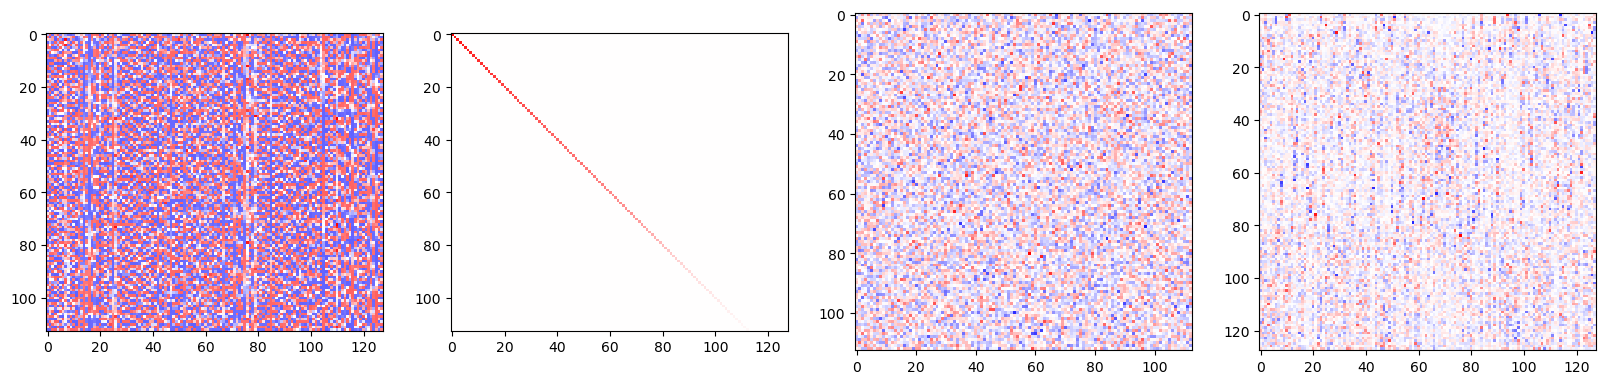

In [27]:
plot_usv(0)

IndexError: list index out of range

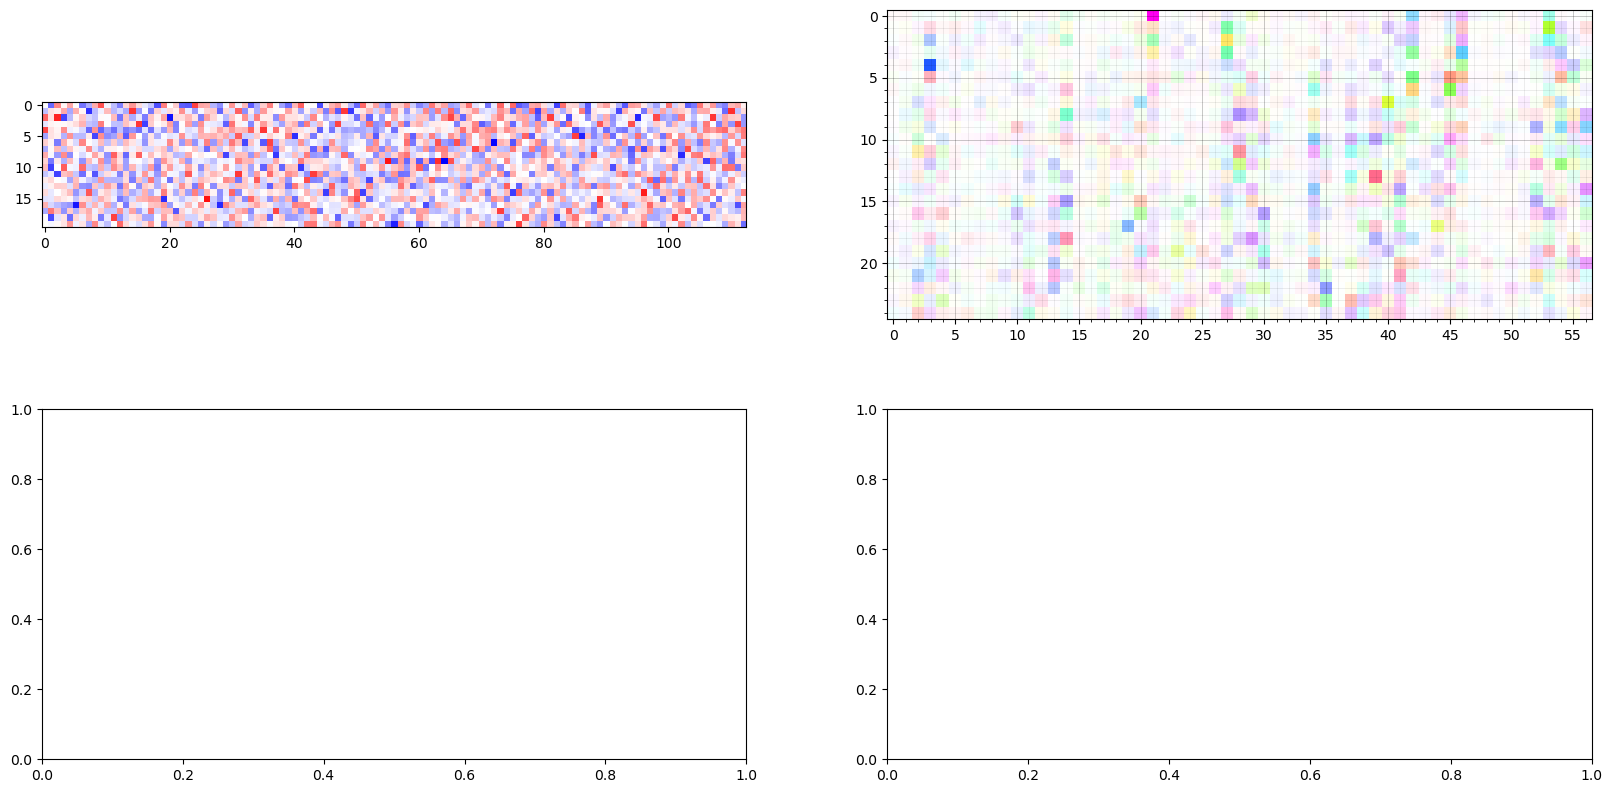

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

plot_matrix(u[0] @ s[0], axs[0,0], transpose=True, numlines=20)
plot_fft((u[0] @ s[0]).T[:25], axs[0,1], shift=+np.pi/2)
plot_matrix(s[2] @ vt[2], axs[1,0], transpose=False, numlines=20)
plot_fft((s[2] @ vt[2])[:25], axs[1,1], shift=+np.pi/2)

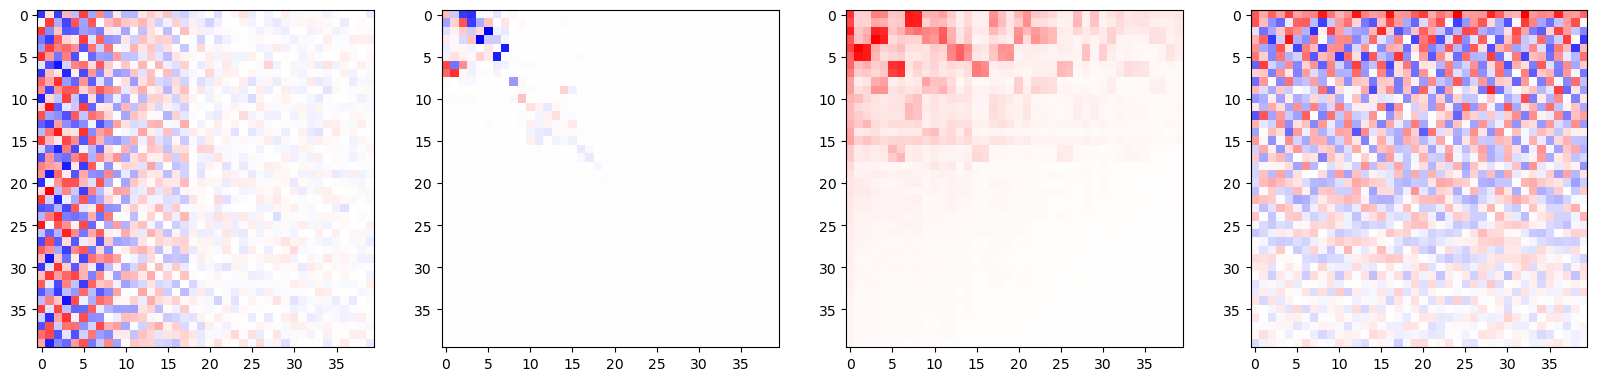

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
plot_matrix((u[0] @ s[0])[:40,:40], axs[0])
plot_matrix((s[0] @ vt[0] @ u[1] @ s[1])[:40,:40], axs[1])
#plot_matrix((gelu(s[1] @ vt[1]) @ u[2] @ s[2])[:40,:40], axs[2])
plot_matrix((s[1] @ np.abs(vt[1]) @ np.abs(u[2]) @ s[2])[:40,:40], axs[2])
plot_matrix((s[2] @ vt[2])[:40,:40], axs[3])


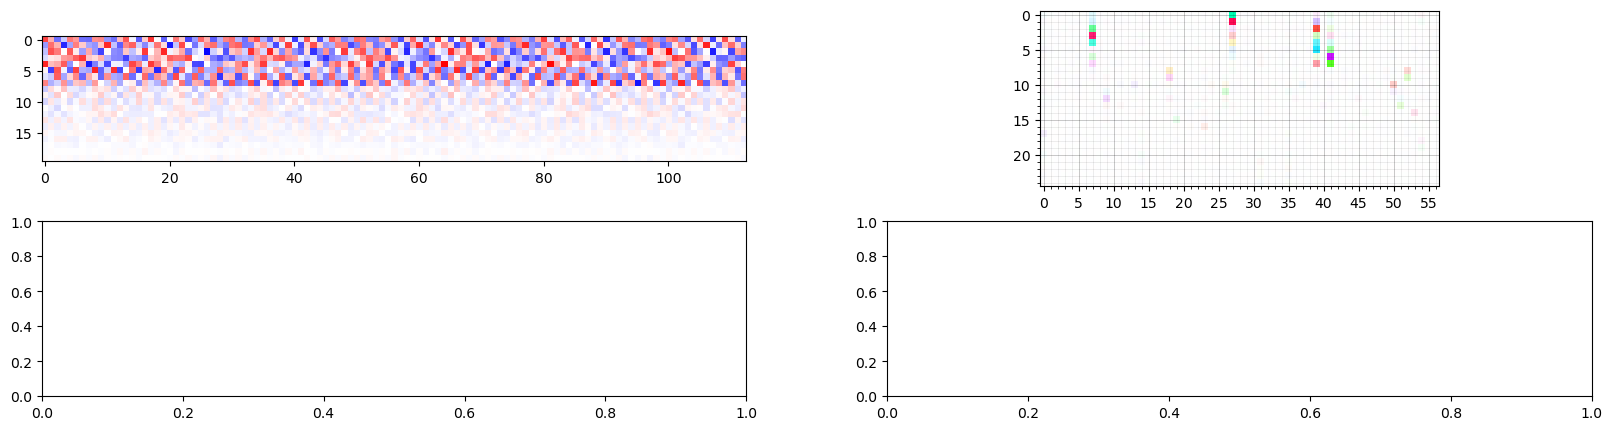

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20,5))

plot_matrix(w[0] @ u[1] @ s[1], axs[0,0], transpose=True, numlines=20)
plot_fft((w[0] @ u[1] @ s[1]).T[:25], axs[0,1], shift=-np.pi/2)
#plot_matrix(s[2] @ vt[2], axs[1,0], transpose=False, numlines=20)
#plot_fft((s[2] @ vt[2])[:25], axs[1,1], shift=+np.pi/2)

In [17]:
m = (u[0] @ s[0])[:,:8]
fft = np.fft.rfft(m, axis=0).T
fft_abs, fft_arg = np.abs(fft), np.angle(fft)
fft.shape

(8, 57)

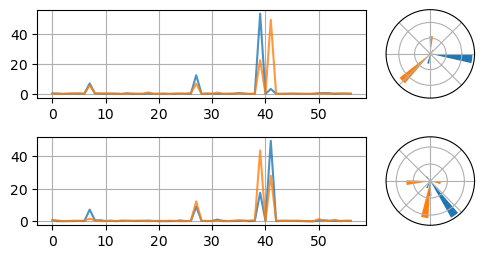

In [18]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(4,4,(1,3))
ax0 = ax
ax.grid(True)
ax.plot(fft_abs[0], alpha=0.8)
ax.plot(fft_abs[1], alpha=0.8)

ax = plt.subplot(4,4,(5,7), sharex=ax0)
ax.grid(True)
ax.plot(fft_abs[2], alpha=0.8)
ax.plot(fft_abs[3], alpha=0.8)

ax = plt.subplot(4,4,4, polar=True)
ax.grid(True)
ax.bar(fft_arg[0], fft_abs[0], width=.2)
ax.bar(fft_arg[1], fft_abs[1], width=.2)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

ax = plt.subplot(4,4,8, polar=True)
ax.grid(True)
ax.bar(fft_arg[2], fft_abs[2], width=.2)
ax.bar(fft_arg[3], fft_abs[3], width=.2)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

plt.tight_layout()


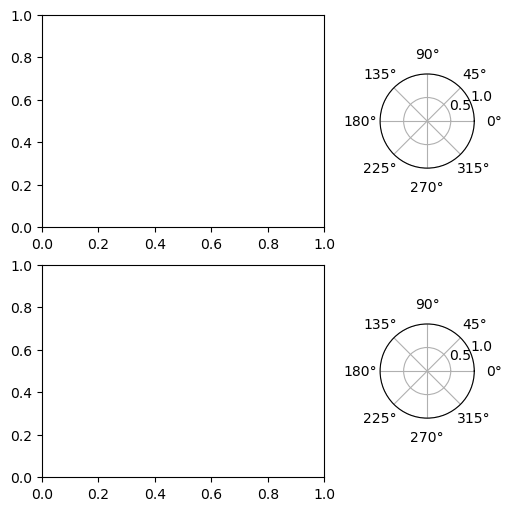

In [81]:
fig = plt.figure(layout="constrained", figsize=(5,5))
axd = fig.subplot_mosaic(
    "01;23",
    per_subplot_kw={
        ("1", "3") : {"projection": "polar"},
    },
    width_ratios=[3,1]
)

In [137]:
m = (vt[0] @ u[1] @ s[1])[:2,:2]
np.sqrt(2) * m / np.linalg.norm(m)

array([[-0.91094327, -0.4218747 ],
       [ 0.39270234, -0.9154172 ]], dtype=float32)

Text(0.5, 1.0, 'A line plot on a polar axis')

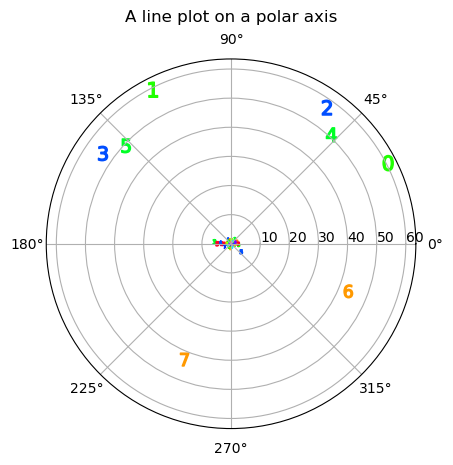

In [300]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
crange = np.arange(len(fft_arg[0]))
for i in range(8):
    ax.scatter(fft_arg[i], fft_abs[i], marker="$"+str(i)+"$", c=crange, cmap="gist_rainbow", s=fft_abs[i]*2)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')

Text(0.5, 1.0, 'A line plot on a polar axis')

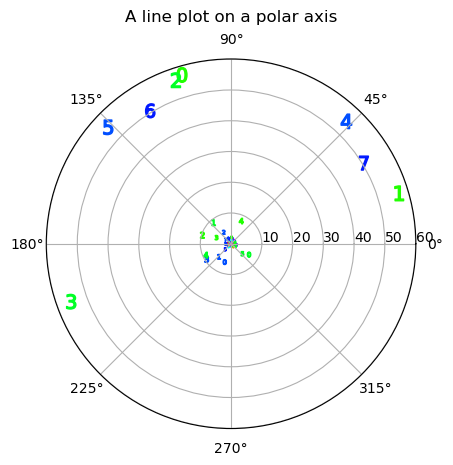

In [309]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
crange = np.arange(len(fft_arg[0]))
for i in range(8):
    ax.scatter(fft_arg[i], fft_abs[i], marker="$"+str(i)+"$", c=crange, cmap="gist_rainbow", s=fft_abs[i]*2)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')

In [19]:
vt[0].shape

(128, 128)

In [99]:
def func(a, b):
    i = np.zeros((1,128), dtype=np.float32)
    i[0,0] = a
    i[0,1] = b
    o = gelu(i @ vt[1]) @ u[2] @ s[2]
    #o = i @ vt[0] @ u[1] @ s[1]
    return o[0,0], o[0,1]

In [100]:
func(1,1)

(-0.0021172108, -0.69027203)

In [101]:
f_plot = np.array([ [ func(a,b) for b in np.linspace(-100,100,100) ] for a in np.linspace(-100,100,100) ])

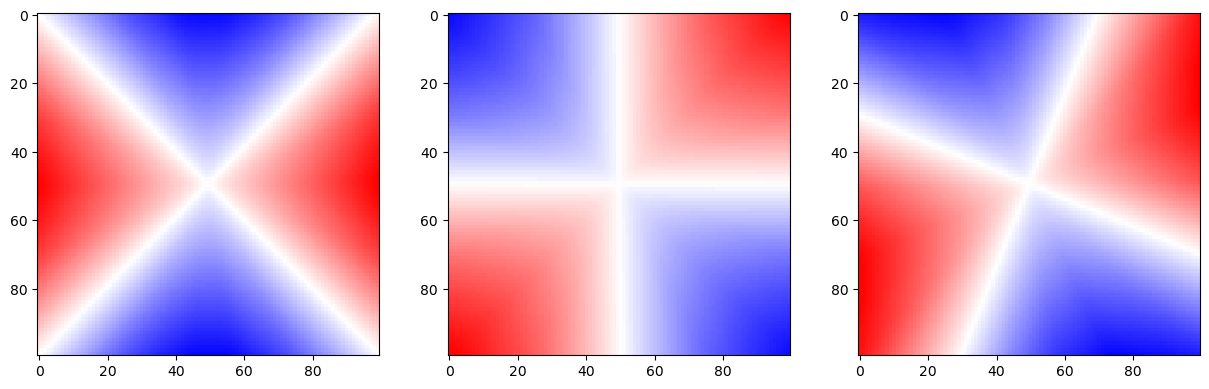

In [102]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

plot_matrix(f_plot[:,:,0], axs[0])
plot_matrix(f_plot[:,:,1], axs[1])
plot_matrix(f_plot.sum(axis=-1), axs[2])


In [118]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso

In [120]:
a_max = 10
steps = 20

ab = np.array([ [a,b] for a in np.linspace(-a_max, a_max, steps) for b in np.linspace(-a_max, a_max, steps)])
o = [ (func(*v))[0] for v in ab ]

poly = PolynomialFeatures(degree=2)
poly_feat = poly.fit_transform(ab)

In [121]:
poly_feat.shape

(400, 6)

In [122]:
# Linear regression
#model_lin = LinearRegression()
model_lin = Lasso()
model_lin.fit(poly_feat, o)

# Display coefficients
print(dict(zip(poly.get_feature_names_out(), model_lin.coef_.round(4))))

{'1': 0.0, 'x0': -0.0, 'x1': 0.0, 'x0^2': -0.1791, 'x0 x1': -0.0057, 'x1^2': 0.1834}


In [123]:
model_lin.coef_ / model_lin.coef_[-1]

array([ 0.        , -0.        ,  0.        , -0.97661253, -0.03115895,
        1.        ])